## Perform supplementary dimensionality scaling experiment

In [1]:
%load_ext autoreload
%autoreload 2

### Load the configs and setup to the plotting

In [2]:
import os
import time

from omegaconf import OmegaConf
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
# inline plotting
%matplotlib inline

from labproject.experiments import Experiment, ScaleDim, ScaleSampleSize
from labproject.utils import get_log_path, get_cfg, set_seed, get_cfg_from_file
from labproject.metrics import METRICS
from labproject.data import DATASETS, DISTRIBUTIONS, get_dataset
from labproject.experiments import *
from labproject.plotting import cm2inch, generate_palette, color_dict

print("Running experiments...")
# load the config file
cfg = get_cfg_from_file("conf_supp_dim_scaling_experiment")
cfg.running_user = 'scaling_dims'
seed = cfg.seed

set_seed(seed)
print(f"Seed: {seed}")
print(f"Experiments: {cfg.experiments}") 
print(f"Data: {cfg.data}")

# assert cfg.data is list
assert len(cfg.data) == len(cfg.n) == len(cfg.d), "Data, n and d must be lists of the same length"
    
# setup the colors
color_dict = {"wasserstein": "#cc241d",
              "mmd": "#eebd35",
              "c2st": "#458588",
              "fid": "#8ec07c", 
              "kl": "#8ec07c"}


col_map = {'ScaleDimKL':'kl', 'ScaleDimSW':'wasserstein',
           'ScaleDimMMD':'mmd', 'ScaleDimC2ST':'c2st',
           'ScaleDimFID':'fid', }

# dark and light colors for inter vs. intra comparisons 
col_dark = {}
col_light = {}
for e, exp_name in enumerate(cfg.experiments):
    col_dark[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='dark')[2]
    col_light[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='light')[-1]
color_list = [col_light, col_dark] # make this a list to account for true and shifted

# Mapping to the abbrev for the distances
mapping = {'ScaleDimKL':'KL', 'ScaleDimSW':'SW',
        'ScaleDimMMD':'MMD', 'ScaleDimC2ST':'C2ST',
        'ScaleDimFID':'FD'}

Running experiments...
Seed: 1404
Experiments: ['ScaleDimSW', 'ScaleDimC2ST', 'ScaleDimMMD']
Data: ['multivariate_normal']


## Loop over the three dataset conditions for the dimensionality sclaing experiments

Dataset shape: torch.Size([25000, 100])
Dataset shape: torch.Size([25000, 100])
Distort: SHIFT_ONE


NameError: name 'time_start' is not defined

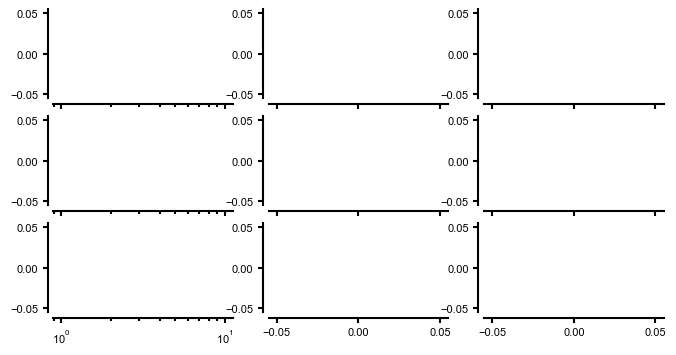

In [3]:
# make comparison plots
fig, axes = plt.subplots(len(cfg.experiments), len(cfg.distort), figsize=cm2inch((20, 10)), sharex='col')
for ax in axes.flatten():
    # move spines outward
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.locator_params(nbins=4)

# Base datasets
dataset_fn = get_dataset(name=cfg.data[0])
dataset_gt = dataset_fn(cfg.n[0]*cfg.runs, cfg.d[0], distort=None)
dataset_intra = dataset_fn(cfg.n[0]*cfg.runs, cfg.d[0], distort=None)
print(f"Dataset shape: {dataset_gt.shape}")
print(f"Dataset shape: {dataset_intra.shape}")

for d, distort in enumerate(cfg.distort):
    print(f"Distort: {distort.upper()}")
    label_true = {}
    label_shift = {}
    for e, data_name in enumerate(cfg.data):
        label_true[data_name] = "true"
        if distort == 'shift_one' or distort=='shift_all':
            label_shift[data_name] = 'shifted'
        if distort == 'increase_var':
            label_shift[data_name] = 'increased var'
    label_list = [label_true, label_shift]

    # Distorted 
    dataset_inter = dataset_fn(cfg.n[0]*cfg.runs, cfg.d[0], distort=cfg.distort[d])
    dataset_inter_var = dataset_fn(cfg.n[0]*cfg.runs, cfg.d[0], distort=cfg.distort[d])

    for e, exp_name in enumerate(cfg.experiments):
        experiment = globals()[exp_name]()
        dataset1 = dataset_gt
        ax = axes[e, d]
        ax.set_xscale('log')
        for dc, data_comp in enumerate([dataset_intra, dataset_inter]):
            dataset2 = data_comp
            assert dataset1.shape == dataset2.shape, f"Dataset shapes do not match: {dataset1.shape} vs. {dataset2.shape}"
            time_start = time.time()
            if mapping[exp_name]  == 'MMD':
                print(f'MMD {cfg.data} {d} {cfg.mmd_bandwidth[d]}')
                output = experiment.run_experiment(dataset1=dataset1,
                                                dataset2=dataset2,
                                                dataset_size = cfg.n[0],
                                                dim_sizes=cfg.dim_sizes,
                                                nb_runs = cfg.runs,
                                                bandwidth=cfg.mmd_bandwidth[d])
            else:
                output = experiment.run_experiment(dataset1=dataset1,
                                                    dataset2=dataset2,
                                                    dataset_size = cfg.n[0],
                                                    dim_sizes=cfg.dim_sizes,
                                                    nb_runs = cfg.runs)
            time_end = time.time()
            print(f"Experiment {exp_name} finished in {time_end - time_start}")

            log_path = get_log_path(cfg)
            os.makedirs(os.path.dirname(log_path), exist_ok=True)
            experiment.log_results(output, log_path)
            print(f"Numerical results saved to {log_path}")
            experiment.plot_experiment(
                *output,
                cfg.data[0],
                ax=ax,
                color=color_list[dc][exp_name],
                label=label_list[dc][cfg.data[0]],
                linestyle='-' if dc == 0 else '--',
                lw=2, 
                marker='o'
            )
            if mapping[exp_name]  == 'MMD':
                ax.set_ylabel(mapping[exp_name]+ str(int(cfg.mmd_bandwidth[d])))
            else:
                ax.set_ylabel(mapping[exp_name])
            ax.set_xlabel('')
            if mapping[exp_name]  == 'C2ST':
                ax.set_ylim([0.45,1.05])
                ax.set_yticks([0.5,1.0])
            
            # Make all y-labels at the same position
            ax.yaxis.set_label_coords(-0.25, 0.5)
            
        ax.legend()

axes[-1, 0].set_xlabel('dimensions')
axes[-1, 1].set_xlabel('dimensions')
axes[-1, 2].set_xlabel('dimensions')

fig.tight_layout()
fig.savefig(f"./results/plots/{cfg.exp_log_name}_metric_comparison_sim_budget_{cfg.n[0]}_dim_size_{cfg.data[0]}_adapted_bandwidth.png", dpi=300)
fig.savefig(f"./results/plots/{cfg.exp_log_name}_metric_comparison_sim_budget_{cfg.n[0]}_dim_size_{cfg.data[0]}_adapted_bandwidth.pdf", dpi=300)

print(f"Plots saved")
print("Finished running experiments.")
